In [1]:
# Install required packages
!pip install flask pandas numpy scikit-learn nltk torch wordcloud matplotlib seaborn tensorflow gensim
# !pip install transformers==4.30.0

# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from flask import Flask, request, jsonify
import threading
import time
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, SimpleRNN, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
from transformers import TFBertForSequenceClassification, BertTokenizer
import gensim.downloader as api
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diwan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diwan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Loading data...
Dataset size: 4000
Fake news: 2000, True news: 2000
Preprocessing texts...
Training models...
Training Naive Bayes...
Naive Bayes - Accuracy: 0.9400, Precision: 0.9338, Recall: 0.9478, F1: 0.9407
Training Logistic Regression...
Logistic Regression - Accuracy: 0.9650, Precision: 0.9539, Recall: 0.9776, F1: 0.9656
Training SVM...
SVM - Accuracy: 0.9712, Precision: 0.9588, Recall: 0.9851, F1: 0.9718
Best traditional model: SVM with accuracy: 0.9712
Loading pretrained embeddings...
Loading glove embeddings...
Training sequence models with pretrained embeddings...
Training SimpleRNN with pretrained embeddings...
Found embeddings for 9696 words out of 10000
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5106 - loss: 0.7378 - val_accuracy: 0.7375 - val_loss: 0.5832
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7716 - loss: 0.5399 - val_accuracy: 0.8288 - val_loss: 0.4584
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8

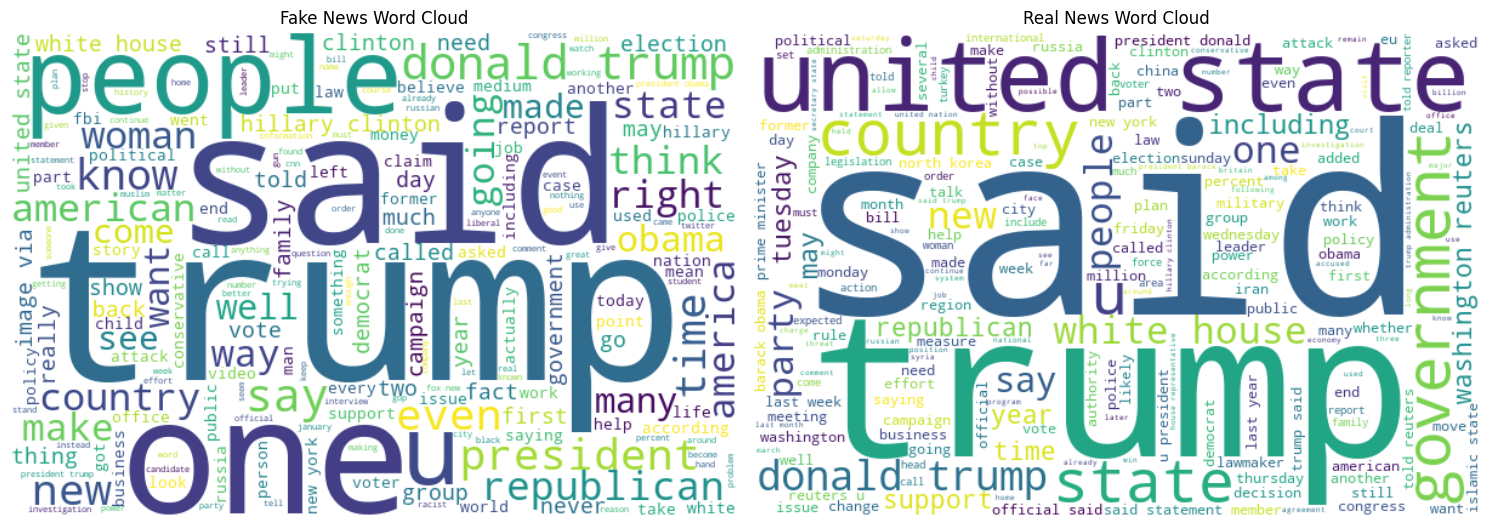

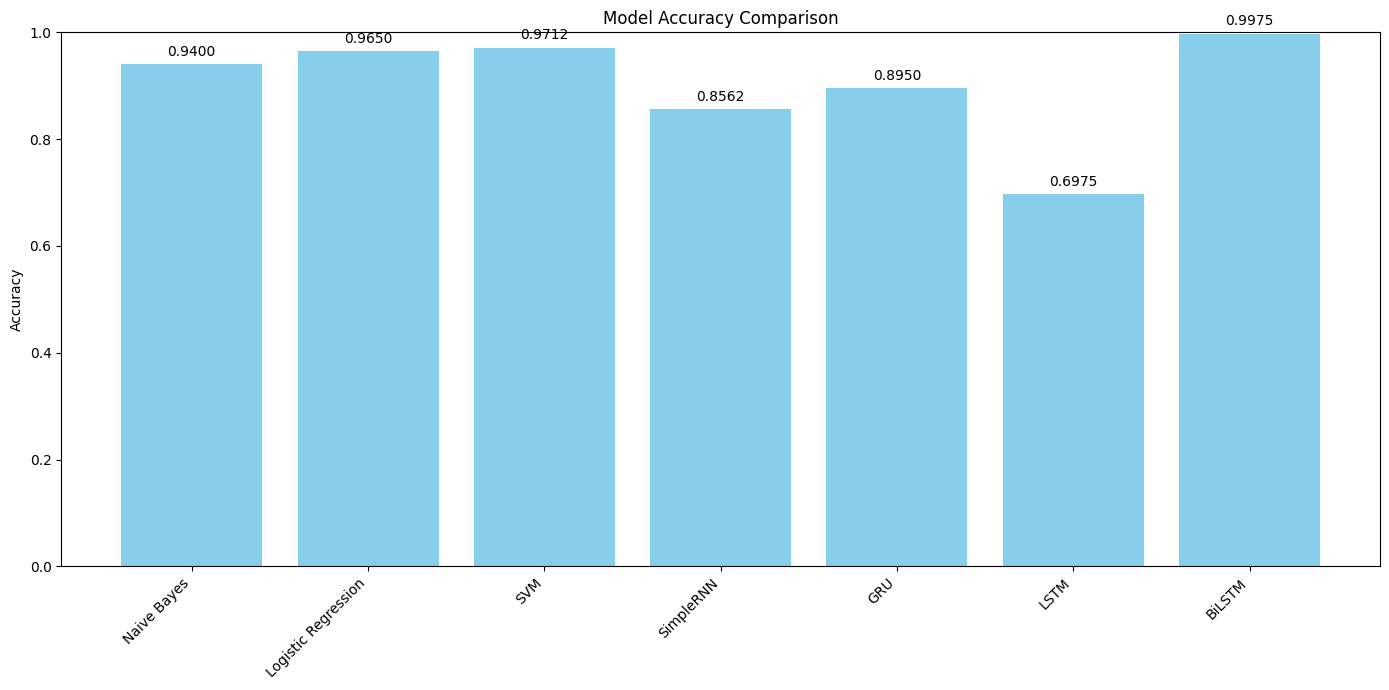

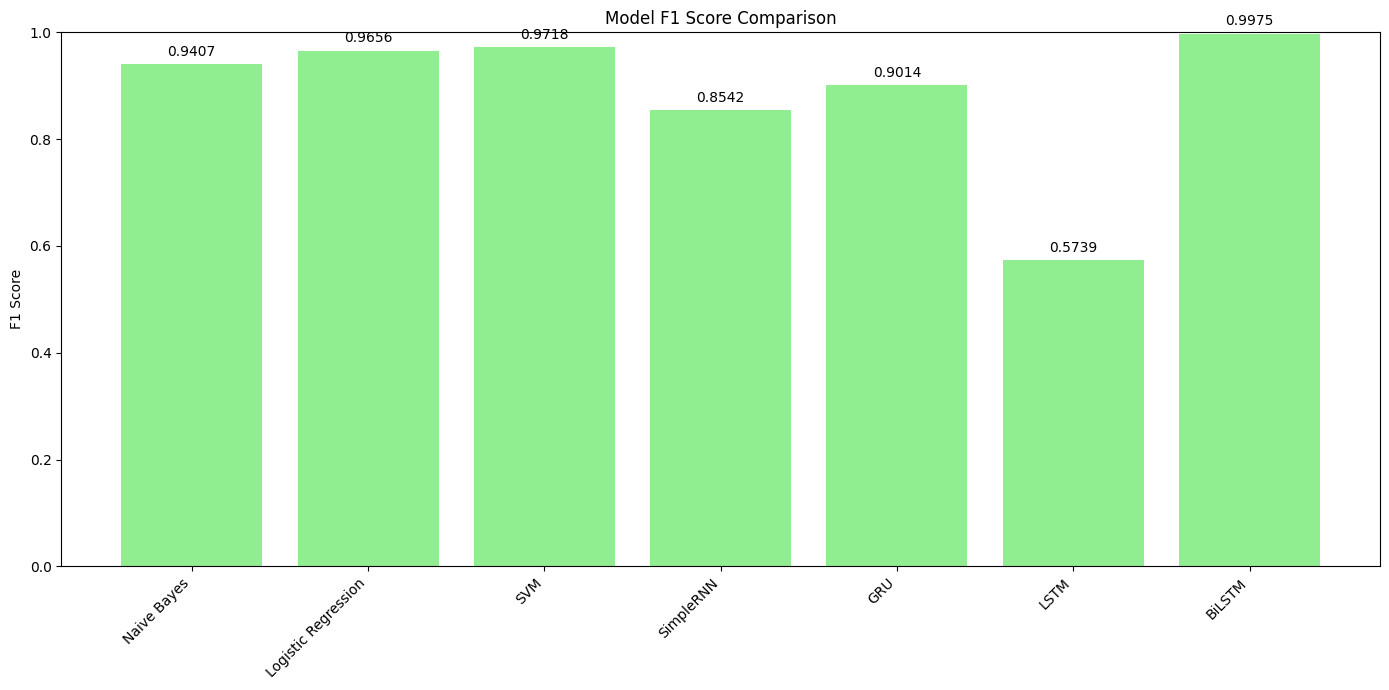

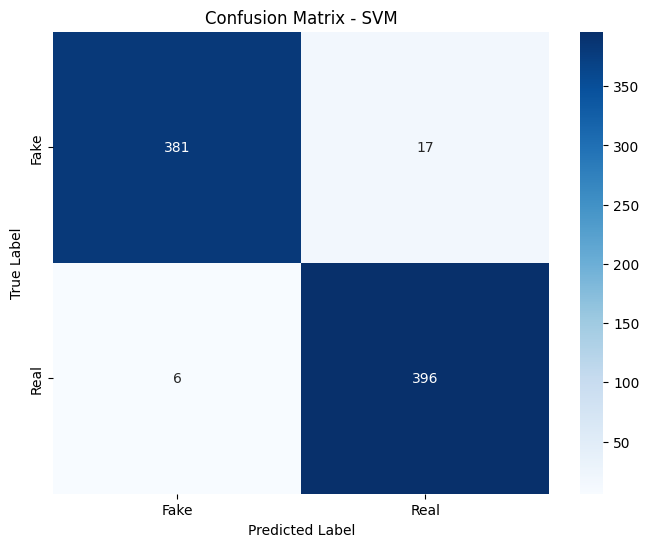

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


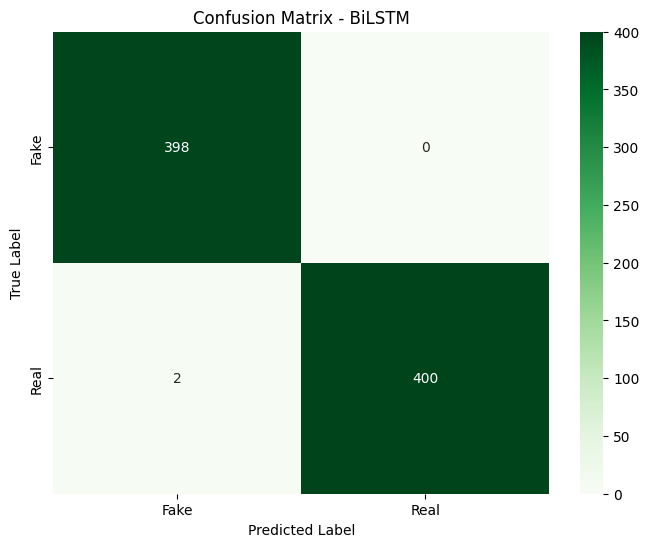

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.8:5000
Press CTRL+C to quit


Flask server is running in the background!
You can access the API at: http://localhost:5000

Available endpoints:
  GET  /          - Web interface with documentation
  POST /predict   - Analyze news text
  GET  /models    - Get model information


In [2]:
# Initialize Flask app
app = Flask(__name__)

# Create a fake news detector class
class EnhancedFakeNewsDetector:
    def __init__(self):
        # Traditional ML components
        self.vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        self.model = None
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.is_trained = False
        self.models = {}
        self.best_model = None
        self.best_accuracy = 0
        
        # Deep learning components
        self.tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
        self.max_length = 200
        self.vocab_size = 10000
        self.embedding_dim = 300  # Increased for pretrained embeddings
        self.sequence_models = {}
        self.transformer_models = {}
        self.pretrained_embeddings = None
        self.use_pretrained_embeddings = False
        
        # Transformer components
        self.bert_tokenizer = None
        self.distilbert_tokenizer = None
        
# -----------------------------------------------------------------------------------------------------------------
    # Preprocess: cleaning text, lowercasing, stopwords, punctuation removal.
    # Tokenization, lemmatization.
    
    def preprocess_text(self, text):
        """Clean and preprocess text"""
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|\#', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Tokenize and remove stopwords
        tokens = nltk.word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]
        
        return ' '.join(tokens)
# ----------------------------------------------------------------------------------------------------------------- 
    # Acquire dataset (CSV).
    def load_and_preprocess_data(self, fake_path, true_path, sample_size=None):
        """Load and preprocess the dataset"""
        print("Loading data...")
        
        try:
            # Load fake and true news
            fake_news = pd.read_csv(fake_path)
            true_news = pd.read_csv(true_path)
            
            # Sample data
            if sample_size:
                fake_news = fake_news.sample(min(sample_size, len(fake_news)), random_state=42)
                true_news = true_news.sample(min(sample_size, len(true_news)), random_state=42)
            
            # Add labels
            fake_news['label'] = 0  # Fake news
            true_news['label'] = 1  # True news
            
            # Combine datasets
            data = pd.concat([fake_news, true_news], ignore_index=True)
            
            # Shuffle the data
            data = data.sample(frac=1, random_state=42).reset_index(drop=True)
            
            print(f"Dataset size: {len(data)}")
            print(f"Fake news: {len(fake_news)}, True news: {len(true_news)}")
            
            # Preprocess texts
            print("Preprocessing texts...")
            data['cleaned_text'] = data['text'].apply(self.preprocess_text)
            
            return data
            
        except Exception as e:
            print(f"Error loading data: {e}")

# ----------------------------------------------------------------------------------------------------------------- 
    # Use pretrained embeddings (Word2Vec, GloVe, FastText).
    def prepare_sequences(self, texts, training=True):
        """Prepare text sequences for deep learning models"""
        if training:
            self.tokenizer.fit_on_texts(texts)
        
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')
        
        return padded_sequences
    
    def load_pretrained_embeddings(self, embedding_type='glove'):
        """Load pretrained word embeddings"""
        print(f"Loading {embedding_type} embeddings...")
        
        try:
            if embedding_type.lower() == 'glove':
                # Load GloVe embeddings (using gensim's downloader)
                print("Downloading GloVe embeddings...")
                glove_vectors = api.load("glove-wiki-gigaword-300")
                self.pretrained_embeddings = glove_vectors
                self.embedding_dim = 300
                return glove_vectors
                
            elif embedding_type.lower() == 'word2vec':
                # Load Word2Vec embeddings
                print("Downloading Word2Vec embeddings...")
                w2v_vectors = api.load("word2vec-google-news-300")
                self.pretrained_embeddings = w2v_vectors
                self.embedding_dim = 300
                return w2v_vectors
                
            elif embedding_type.lower() == 'fasttext':
                # Load FastText embeddings
                print("Downloading FastText embeddings...")
                ft_vectors = api.load("fasttext-wiki-news-subwords-300")
                self.pretrained_embeddings = ft_vectors
                self.embedding_dim = 300
                return ft_vectors
                
        except Exception as e:
            print(f"Error loading {embedding_type} embeddings: {e}")
            return None
    
    def create_embedding_matrix(self):
        """Create embedding matrix for pretrained embeddings"""
        if not self.pretrained_embeddings:
            return None
            
        embedding_matrix = np.zeros((self.vocab_size, self.embedding_dim))
        found_words = 0
        
        for word, i in self.tokenizer.word_index.items():
            if i >= self.vocab_size:
                continue
            try:
                if word in self.pretrained_embeddings:
                    embedding_vector = self.pretrained_embeddings[word]
                    embedding_matrix[i] = embedding_vector
                    found_words += 1
            except:
                continue
                
        print(f"Found embeddings for {found_words} words out of {self.vocab_size}")
        return embedding_matrix

# ----------------------------------------------------------------------------------------------------------------- 
    # sequence models: RNN, GRU, LSTM, + BiLSTM
    
    def build_rnn_model(self, units=64, rnn_type='simple'):
        """Build an RNN model with pretrained embeddings"""
        model = Sequential()
        
        if self.use_pretrained_embeddings and self.pretrained_embeddings:
            embedding_matrix = self.create_embedding_matrix()
            if embedding_matrix is not None:
                model.add(Embedding(
                    input_dim=self.vocab_size, 
                    output_dim=self.embedding_dim, 
                    weights=[embedding_matrix],
                    input_length=self.max_length,
                    trainable=False  # Freeze embeddings
                ))
            else:
                model.add(Embedding(
                    input_dim=self.vocab_size, 
                    output_dim=self.embedding_dim, 
                    input_length=self.max_length
                ))
        else:
            model.add(Embedding(
                input_dim=self.vocab_size, 
                output_dim=self.embedding_dim, 
                input_length=self.max_length
            ))
        
        if rnn_type.lower() == 'simple':
            model.add(SimpleRNN(units, return_sequences=False))
        elif rnn_type.lower() == 'gru':
            model.add(GRU(units, return_sequences=False))
        elif rnn_type.lower() == 'lstm':
            model.add(LSTM(units, return_sequences=False))
        elif rnn_type.lower() == 'bilstm':
            model.add(Bidirectional(LSTM(units, return_sequences=False)))
        
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model

# ----------------------------------------------------------------------------------------------------------------- 
    # Transformer-based models (BERT, DistilBERT)
    
    def train_transformer_model(self, train_texts, train_labels, val_texts, val_labels, model_name='distilbert-base-uncased'):
        """Train a transformer model"""
        print(f"Training {model_name} transformer model...")
        
        # Select appropriate tokenizer and model
        if 'distilbert' in model_name.lower():
            tokenizer = DistilBertTokenizer.from_pretrained(model_name)
            model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
        else:
            tokenizer = BertTokenizer.from_pretrained(model_name)
            model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
        
        # Tokenize the data
        train_encodings = tokenizer(
            train_texts.tolist(),
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors='tf'
        )
        
        val_encodings = tokenizer(
            val_texts.tolist(),
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors='tf'
        )
        
        # Create TensorFlow datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((
            dict(train_encodings),
            train_labels
        )).shuffle(1000).batch(16)
        
        val_dataset = tf.data.Dataset.from_tensor_slices((
            dict(val_encodings),
            val_labels
        )).batch(16)
        
        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        
        # Train model
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=2,  # Small number of epochs for fine-tuning
            verbose=1
        )
        
        # Evaluate model
        predictions = model.predict(val_dataset)
        pred_labels = np.argmax(predictions.logits, axis=1)
        
        accuracy = accuracy_score(val_labels, pred_labels)
        precision = precision_score(val_labels, pred_labels)
        recall = recall_score(val_labels, pred_labels)
        f1 = f1_score(val_labels, pred_labels)
        
        # Store tokenizer for later use
        if 'distilbert' in model_name.lower():
            self.distilbert_tokenizer = tokenizer
        else:
            self.bert_tokenizer = tokenizer
        
        return {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'history': history,
            'tokenizer': tokenizer
        }
    
    def train_sequence_models(self, data):
        """Train sequence models (RNN, GRU, LSTM) with pretrained embeddings"""
        print("Training sequence models with pretrained embeddings...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            data['cleaned_text'], data['label'], test_size=0.2, random_state=42
        )
        
        # Prepare sequences
        X_train_seq = self.prepare_sequences(X_train, training=True)
        X_test_seq = self.prepare_sequences(X_test, training=False)
        
        # Define sequence models to train
        sequence_model_types = [
            ('SimpleRNN', 'simple'),
            ('GRU', 'gru'),
            ('LSTM', 'lstm'),
            ('BiLSTM', 'bilstm')
        ]
        
        # Train each sequence model
        for name, rnn_type in sequence_model_types:
            print(f"Training {name} with pretrained embeddings...")
            
            model = self.build_rnn_model(units=64, rnn_type=rnn_type)
            
            history = model.fit(
                X_train_seq, y_train,
                epochs=5,
                batch_size=32,
                validation_data=(X_test_seq, y_test),
                verbose=1
            )
            
            # Evaluate model
            predictions = (model.predict(X_test_seq) > 0.5).astype("int32")
            accuracy = accuracy_score(y_test, predictions)
            precision = precision_score(y_test, predictions)
            recall = recall_score(y_test, predictions)
            f1 = f1_score(y_test, predictions)
            
            self.sequence_models[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'history': history
            }
            
            print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    def train_transformer_models(self, data):
        """Train transformer models (BERT, DistilBERT)"""
        print("Training transformer models...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            data['cleaned_text'], data['label'], test_size=0.2, random_state=42
        )
        
        # Train DistilBERT
        print("Training DistilBERT...")
        distilbert_results = self.train_transformer_model(
            X_train, y_train, X_test, y_test, 'distilbert-base-uncased'
        )
        self.transformer_models['DistilBERT'] = distilbert_results
        
        # Train BERT
        print("Training BERT...")
        bert_results = self.train_transformer_model(
            X_train, y_train, X_test, y_test, 'bert-base-uncased'
        )
        self.transformer_models['BERT'] = bert_results

# ----------------------------------------------------------------------------------------------------------------- 
    # Fine-tune on dataset for best performance.
    
    def train_models(self, data):
        """Train multiple models and select the best one"""
        print("Training models...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            data['cleaned_text'], data['label'], test_size=0.2, random_state=42
        )
        
        # Create TF-IDF features
        X_train_tfidf = self.vectorizer.fit_transform(X_train)
        X_test_tfidf = self.vectorizer.transform(X_test)
        
        # Define traditional ML models to train
        models = {
            'Naive Bayes': MultinomialNB(),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'SVM': SVC(kernel='linear', random_state=42, probability=True)
        }
        
        # Train and evaluate each model
        for name, model in models.items():
            print(f"Training {name}...")
            model.fit(X_train_tfidf, y_train)
            predictions = model.predict(X_test_tfidf)
            accuracy = accuracy_score(y_test, predictions)
            precision = precision_score(y_test, predictions)
            recall = recall_score(y_test, predictions)
            f1 = f1_score(y_test, predictions)
            
            self.models[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1
            }
            
            print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
            
            # Update best model
            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_model = name
        
        print(f"Best traditional model: {self.best_model} with accuracy: {self.best_accuracy:.4f}")
        
        # Load pretrained embeddings
        print("Loading pretrained embeddings...")
        self.load_pretrained_embeddings('glove')  # Can be changed to 'word2vec' or 'fasttext'
        self.use_pretrained_embeddings = True
        
        # Train sequence models with pretrained embeddings
        self.train_sequence_models(data)
        
        # Train transformer models
        # self.train_transformer_models(data)
        
        self.is_trained = True
        
        # Generate visualizations
        self.generate_visualizations(data, X_test_tfidf, y_test)
            

# ----------------------------------------------------------------------------------------------------------------- 
    # Visualization: Word clouds , Confusion matrices , F1-score
    
    def generate_visualizations(self, data, X_test, y_test):
        """Generate visualizations for the data and models"""
        print("Generating visualizations...")
        
        # Word clouds for fake vs real news
        fake_texts = ' '.join(data[data['label'] == 0]['cleaned_text'])
        real_texts = ' '.join(data[data['label'] == 1]['cleaned_text'])
        
        plt.figure(figsize=(15, 8))
        
        plt.subplot(1, 2, 1)
        wordcloud = WordCloud(width=600, height=400, background_color='white').generate(fake_texts)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Fake News Word Cloud')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        wordcloud = WordCloud(width=600, height=400, background_color='white').generate(real_texts)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Real News Word Cloud')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Model comparison for traditional models
        model_names = list(self.models.keys())
        accuracies = [self.models[name]['accuracy'] for name in model_names]
        f1_scores = [self.models[name]['f1'] for name in model_names]
        
        # Model comparison for sequence models
        seq_model_names = list(self.sequence_models.keys())
        seq_accuracies = [self.sequence_models[name]['accuracy'] for name in seq_model_names]
        seq_f1_scores = [self.sequence_models[name]['f1'] for name in seq_model_names]
        
        # Model comparison for transformer models
        transformer_model_names = list(self.transformer_models.keys())
        transformer_accuracies = [self.transformer_models[name]['accuracy'] for name in transformer_model_names]
        transformer_f1_scores = [self.transformer_models[name]['f1'] for name in transformer_model_names]
        
        # Combine all models for comparison
        all_model_names = model_names + seq_model_names + transformer_model_names
        all_accuracies = accuracies + seq_accuracies + transformer_accuracies
        all_f1_scores = f1_scores + seq_f1_scores + transformer_f1_scores
        
        # Create a DataFrame for easier plotting
        model_comparison = pd.DataFrame({
        'Model': all_model_names,
        'Accuracy': all_accuracies,
        'F1 Score': all_f1_scores
        })

        # Plot accuracy comparison
        plt.figure(figsize=(14, 7))
        bars = plt.bar(model_comparison['Model'], model_comparison['Accuracy'], color='skyblue')
        plt.title('Model Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)
        
        # Add value labels on bars
        for bar, accuracy in zip(bars, model_comparison['Accuracy']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{accuracy:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Plot F1 score comparison
        plt.figure(figsize=(14, 7))
        bars = plt.bar(model_comparison['Model'], model_comparison['F1 Score'], color='lightgreen')
        plt.title('Model F1 Score Comparison')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)
        
        # Add value labels on bars
        for bar, f1_score in zip(bars, model_comparison['F1 Score']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{f1_score:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Confusion matrix for best traditional model
        best_model = self.models[self.best_model]['model']
        y_pred = best_model.predict(X_test)
        
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
        plt.title(f'Confusion Matrix - {self.best_model}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Confusion matrix for best sequence model
        if self.sequence_models:
            best_seq_model_name = max(self.sequence_models.items(), key=lambda x: x[1]['accuracy'])[0]
            best_seq_model = self.sequence_models[best_seq_model_name]['model']
            
            # Get the test texts that were used for sequence model training
            # We need to recreate the same split that was used during training
            X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
                data['cleaned_text'], data['label'], test_size=0.2, random_state=42
            )
            
            # Prepare sequences for test data
            X_test_seq_prepared = self.prepare_sequences(X_test_seq, training=False)
            
            seq_predictions = (best_seq_model.predict(X_test_seq_prepared) > 0.5).astype("int32")
            
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test_seq, seq_predictions)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                       xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
            plt.title(f'Confusion Matrix - {best_seq_model_name}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
        
        # Confusion matrix for best transformer model
        if self.transformer_models:
            best_transformer_name = max(self.transformer_models.items(), key=lambda x: x[1]['accuracy'])[0]
            best_transformer = self.transformer_models[best_transformer_name]['model']
            
            # Get the test texts that were used for transformer training
            X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(
                data['cleaned_text'], data['label'], test_size=0.2, random_state=42
            )
    
            # Tokenize test data
            tokenizer = self.transformer_models[best_transformer_name]['tokenizer']
            test_encodings = tokenizer(
                X_test_trans.tolist(),
                truncation=True,
                padding=True,
                max_length=128,
                return_tensors='tf'
            )
            
            test_dataset = tf.data.Dataset.from_tensor_slices((
                dict(test_encodings),
                y_test_trans
            )).batch(16)
            
            # Make predictions
            predictions = best_transformer.predict(test_dataset)
            transformer_preds = np.argmax(predictions.logits, axis=1)
            
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test_trans, transformer_preds)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                       xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
            plt.title(f'Confusion Matrix - {best_transformer_name}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
    
    def predict(self, text):
        """Predict if text is fake news using the best model"""
        if not self.is_trained:
            return "Model not trained yet", [], 0
        
        # Preprocess text
        processed_text = self.preprocess_text(text)
        
        # Transform text for traditional models
        text_vector = self.vectorizer.transform([processed_text])
        
        # Prepare sequence for deep learning models
        text_sequence = self.prepare_sequences([processed_text], training=False)
        
        # Predict with best traditional model
        best_model = self.models[self.best_model]['model']
        prediction = best_model.predict(text_vector)
        probability = best_model.predict_proba(text_vector)
        
        # Predict with sequence models
        seq_predictions = {}
        for name, model_info in self.sequence_models.items():
            seq_pred = (model_info['model'].predict(text_sequence) > 0.5).astype("int32")
            seq_prob = model_info['model'].predict(text_sequence)
            seq_predictions[name] = {
                'prediction': "Fake" if seq_pred[0][0] == 0 else "Real",
                'confidence': float(seq_prob[0][0] if seq_pred[0][0] == 1 else 1 - seq_prob[0][0])
            }
        
        # Predict with transformer models
        transformer_predictions = {}
        for name, model_info in self.transformer_models.items():
            tokenizer = model_info['tokenizer']
            model = model_info['model']
            
            # Tokenize input
            inputs = tokenizer(
                processed_text,
                return_tensors='tf',
                truncation=True,
                padding=True,
                max_length=128
            )
            
            # Make prediction
            outputs = model(inputs)
            probs = tf.nn.softmax(outputs.logits, axis=-1)
            pred_label = np.argmax(probs, axis=1)[0]
            
            transformer_predictions[name] = {
                'prediction': "Fake" if pred_label == 0 else "Real",
                'confidence': float(probs[0][pred_label])
            }
        
        # Get all model predictions
        all_predictions = {}
        for name, model_info in self.models.items():
            model_pred = model_info['model'].predict(text_vector)
            model_prob = model_info['model'].predict_proba(text_vector)
            all_predictions[name] = {
                'prediction': "Fake" if model_pred[0] == 0 else "Real",
                'confidence': float(max(model_prob[0]))
            }
        
        # Add sequence model predictions
        all_predictions.update(seq_predictions)
        
        # Add transformer model predictions
        all_predictions.update(transformer_predictions)
        
        return "Fake" if prediction[0] == 0 else "Real", all_predictions, float(max(probability[0]))

# -----------------------------------------------------------------------------------------------------------------
    # Sentiment Analysis : Positive / Negative / Neutral
    
    def analyze_sentiment(self, text):
        """Simple sentiment analysis"""
        positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'positive', 
                         'happy', 'joy', 'love', 'best', 'better', 'beautiful', 'nice', 'success']
        negative_words = ['bad', 'terrible', 'awful', 'horrible', 'disappointing', 'negative',
                         'sad', 'hate', 'worst', 'worse', 'ugly', 'not good', 'dislike', 'fail']
        
        text_lower = text.lower()
        positive_score = sum(1 for word in positive_words if word in text_lower)
        negative_score = sum(1 for word in negative_words if word in text_lower)
        
        if positive_score > negative_score:
            return "Positive", positive_score, negative_score
        elif negative_score > positive_score:
            return "Negative", positive_score, negative_score
        else:
            return "Neutral", positive_score, negative_score

# Create enhanced detector instance
detector = EnhancedFakeNewsDetector()

# Load and preprocess sample data
data = detector.load_and_preprocess_data(
    fake_path='Fake.csv',
    true_path='True.csv',
    sample_size=2000  # Use None to load all data
)

# Train models
detector.train_models(data)

# -----------------------------------------------------------------------------------------------------------------
    # Simple web demo where user pastes a headline/tweet → outputs:

# Define Flask routes
@app.route('/')
def home():
    return """
<html>
<head>
    <title>Enhanced Fake News Detection API</title>
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css">
    <style>
        :root {
            --primary-purple: #6a1b9a;
            --light-purple: #9c4dcc;
            --dark-purple: #38006b;
            --accent-purple: #8e24aa;
            --gradient-start: #6a1b9a;
            --gradient-end: #8e24aa;
            --text-light: #f3e5f5;
            --card-bg: rgba(255, 255, 255, 0.1);
            --shadow: 0 8px 32px rgba(106, 27, 154, 0.3);
        }
        
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        }
        
        body {
            background: linear-gradient(135deg, var(--gradient-start), var(--gradient-end));
            color: var(--text-light);
            min-height: 100vh;
            padding: 20px;
        }
        
        .container {
            max-width: 1000px;
            margin: 0 auto;
        }
        
        header {
            text-align: center;
            margin-bottom: 40px;
            padding: 20px;
        }
        
        h1 {
            font-size: 2.8rem;
            margin-bottom: 10px;
            text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);
        }
        
        .tagline {
            font-size: 1.2rem;
            opacity: 0.9;
        }
        
        .card {
            background: var(--card-bg);
            backdrop-filter: blur(10px);
            border-radius: 15px;
            padding: 25px;
            margin-bottom: 25px;
            box-shadow: var(--shadow);
            border: 1px solid rgba(255, 255, 255, 0.1);
        }
        
        .endpoints {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
            gap: 20px;
            margin-bottom: 30px;
        }
        
        .endpoint {
            background: rgba(255, 255, 255, 0.08);
            border-radius: 12px;
            padding: 20px;
            transition: transform 0.3s ease, box-shadow 0.3s ease;
        }
        
        .endpoint:hover {
            transform: translateY(-5px);
            box-shadow: 0 12px 30px rgba(106, 27, 154, 0.4);
        }
        
        .endpoint h3 {
            color: #e1bee7;
            margin-bottom: 15px;
            display: flex;
            align-items: center;
        }
        
        .endpoint h3 i {
            margin-right: 10px;
        }
        
        .endpoint p {
            margin-bottom: 10px;
            line-height: 1.5;
        }
        
        code {
            background: rgba(0, 0, 0, 0.2);
            padding: 3px 8px;
            border-radius: 4px;
            font-family: monospace;
            display: inline-block;
            margin: 5px 0;
        }
        
        .test-area {
            margin-top: 30px;
        }
        
        textarea {
            width: 100%;
            padding: 15px;
            border-radius: 10px;
            background: rgba(255, 255, 255, 0.1);
            border: 1px solid rgba(255, 255, 255, 0.2);
            color: white;
            font-size: 1rem;
            resize: vertical;
            min-height: 120px;
            margin-bottom: 15px;
        }
        
        textarea::placeholder {
            color: rgba(255, 255, 255, 0.6);
        }
        
        button {
            background: var(--light-purple);
            color: white;
            border: none;
            padding: 12px 25px;
            border-radius: 30px;
            font-size: 1rem;
            cursor: pointer;
            transition: background 0.3s ease, transform 0.2s ease;
            display: inline-flex;
            align-items: center;
            justify-content: center;
        }
        
        button i {
            margin-right: 8px;
        }
        
        button:hover {
            background: var(--accent-purple);
            transform: scale(1.05);
        }
        
        #result {
            margin-top: 25px;
            padding: 20px;
            border-radius: 10px;
            background: rgba(0, 0, 0, 0.2);
            display: none;
        }
        
        .result-content {
            background: rgba(0, 0, 0, 0.3);
            padding: 15px;
            border-radius: 8px;
            overflow-x: auto;
        }
        
        pre {
            white-space: pre-wrap;
            font-family: 'Consolas', monospace;
            line-height: 1.4;
        }
        
        .loading {
            display: none;
            text-align: center;
            margin: 20px 0;
        }
        
        .spinner {
            border: 4px solid rgba(255, 255, 255, 0.3);
            border-radius: 50%;
            border-top: 4px solid var(--light-purple);
            width: 40px;
            height: 40px;
            animation: spin 1s linear infinite;
            margin: 0 auto;
        }
        
        @keyframes spin {
            0% { transform: rotate(0deg); }
            100% { transform: rotate(360deg); }
        }
        
        footer {
            text-align: center;
            margin-top: 50px;
            padding: 20px;
            opacity: 0.7;
            font-size: 0.9rem;
        }
        
        @media (max-width: 768px) {
            .endpoints {
                grid-template-columns: 1fr;
            }
            
            h1 {
                font-size: 2.2rem;
            }
        }
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1><i class="fas fa-newspaper"></i> Enhanced Fake News Detection API</h1>
            <p class="tagline">Advanced detection using ML, transformers, and sentiment analysis</p>
        </header>
        
        <div class="card">
            <p>This API provides comprehensive fake news detection using multiple approaches including traditional machine learning, sequence models with pretrained embeddings, transformers, and sentiment analysis.</p>
        </div>
        
        <div class="endpoints">
            <div class="endpoint">
                <h3><i class="fas fa-paper-plane"></i> POST /predict</h3>
                <p>Predict if a news text is fake or real and analyze its sentiment.</p>
                <p><strong>Request body:</strong></p>
                <code>{"text": "Your news text here"}</code>
                <p><strong>Response:</strong> JSON with prediction, confidence, and sentiment analysis</p>
            </div>
            
            <div class="endpoint">
                <h3><i class="fas fa-cogs"></i> GET /models</h3>
                <p>Get information about all trained models and their performance metrics.</p>
                <p><strong>Response:</strong> JSON with model details and evaluation metrics</p>
            </div>
        </div>
        
        <div class="card test-area">
            <h2><i class="fas fa-vial"></i> Test the API</h2>
            <p>Enter news text below to analyze it for authenticity and sentiment:</p>
            
            <textarea id="newsText" rows="6" placeholder="Paste news article text here..."></textarea>
            
            <button onclick="testAPI()">
                <i class="fas fa-play-circle"></i> Analyze News
            </button>
            
            <div class="loading" id="loading">
                <div class="spinner"></div>
                <p>Analyzing content...</p>
            </div>
            
            <div id="result">
                <h3><i class="fas fa-poll"></i> Analysis Results</h3>
                <div class="result-content">
                    <pre id="resultContent"></pre>
                </div>
            </div>
        </div>
        
        <footer>
            <p>Enhanced Fake News Detection API &copy; 2023</p>
        </footer>
    </div>
    
    <script>
        function testAPI() {
            var text = document.getElementById('newsText').value;
            if (!text) {
                alert('Please enter some text to analyze');
                return;
            }
            
            // Show loading animation
            document.getElementById('loading').style.display = 'block';
            document.getElementById('result').style.display = 'none';
            
            fetch('/predict', {
                method: 'POST',
                headers: {
                    'Content-Type': 'application/json'
                },
                body: JSON.stringify({text: text})
            })
            .then(response => response.json())
            .then(data => {
                // Hide loading animation
                document.getElementById('loading').style.display = 'none';
                
                // Format and display results
                var resultContent = document.getElementById('resultContent');
                resultContent.textContent = JSON.stringify(data, null, 2);
                document.getElementById('result').style.display = 'block';
            })
            .catch(error => {
                document.getElementById('loading').style.display = 'none';
                document.getElementById('result').style.display = 'block';
                document.getElementById('resultContent').textContent = 'Error: ' + error;
            });
        }
    </script>
</body>
</html>
    """

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        text = data.get('text', '')
        
        if not text:
            return jsonify({'error': 'No text provided'}), 400
        
        # Get prediction
        prediction, all_predictions, confidence = detector.predict(text)
        
        # Get sentiment
        sentiment, positive_score, negative_score = detector.analyze_sentiment(text)
        
        return jsonify({
            'prediction': prediction,
            'confidence': confidence,
            'sentiment': sentiment,
            'sentiment_scores': {
                'positive': positive_score,
                'negative': negative_score
            },
            'all_model_predictions': all_predictions,
            'best_traditional_model': detector.best_model,
            'text_preview': text[:100] + '...' if len(text) > 100 else text
        })
    
    except Exception as e:
        return jsonify({'error': str(e)}), 500

@app.route('/models', methods=['GET'])
def get_models():
    try:
        model_info = {}
        
        # Traditional models
        for name, info in detector.models.items():
            model_info[name] = {
                'type': 'Traditional ML',
                'accuracy': info['accuracy'],
                'precision': info['precision'],
                'recall': info['recall'],
                'f1': info['f1'],
                'model_class': str(type(info['model']).split('.')[-1].replace("'>", ""))
            }
        
        # Sequence models
        for name, info in detector.sequence_models.items():
            model_info[name] = {
                'type': 'Sequence Model',
                'accuracy': info['accuracy'],
                'precision': info['precision'],
                'recall': info['recall'],
                'f1': info['f1'],
                'model_class': name
            }
        
        # Transformer models
        for name, info in detector.transformer_models.items():
            model_info[name] = {
                'type': 'Transformer',
                'accuracy': info['accuracy'],
                'precision': info['precision'],
                'recall': info['recall'],
                'f1': info['f1'],
                'model_class': name
            }
        
        # Find best overall model
        all_accuracies = {**{k: v['accuracy'] for k, v in detector.models.items()},
                         **{k: v['accuracy'] for k, v in detector.sequence_models.items()},
                         **{k: v['accuracy'] for k, v in detector.transformer_models.items()}}
        
        best_overall_model = max(all_accuracies.items(), key=lambda x: x[1])
        
        return jsonify({
            'models': model_info,
            'best_traditional_model': detector.best_model,
            'best_traditional_accuracy': detector.best_accuracy,
            'best_overall_model': best_overall_model[0],
            'best_overall_accuracy': best_overall_model[1]
        })
    
    except Exception as e:
        return jsonify({'error': str(e)}), 500

# Function to run Flask app in a thread
def run_flask_app():
    app.run(host='0.0.0.0', port=5000, debug=False, use_reloader=False)

# Start the Flask server in a separate thread
flask_thread = threading.Thread(target=run_flask_app)
flask_thread.daemon = True
flask_thread.start()

# Wait a moment for the server to start
time.sleep(2)

print("Flask server is running in the background!")
print("You can access the API at: http://localhost:5000")
print("")
print("Available endpoints:")
print("  GET  /          - Web interface with documentation")
print("  POST /predict   - Analyze news text")
print("  GET  /models    - Get model information")